
# Modelo de Regresión con Support Vector Regression (SVR)

Este notebook implementa un modelo de Support Vector Regression para predecir el consumo energético.
El objetivo es desarrollar un modelo robusto capaz de realizar predicciones precisas utilizando técnicas de optimización bayesiana y validación cruzada.

## Estructura del Análisis
1. Preparación de Datos: Carga y separación de datasets de entrenamiento y prueba
2. Preprocesamiento: Escalado de características para SVR
3. Modelo Básico: Implementación inicial con parámetros por defecto
4. Optimización: Búsqueda bayesiana de hiperparámetros
5. Evaluación: Métricas completas en entrenamiento y prueba
6. Comparación: Análisis de diferentes kernels
7. Visualización: Gráficos de rendimiento y residuos
8. Persistencia: Guardado del modelo y resultados

## Importación de Librerías
Se importan todas las dependencias necesarias para el análisis de regresión

In [1]:
import seaborn as sns
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from skopt import BayesSearchCV
from skopt.space import Real, Categorical
import joblib
import warnings
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

warnings.filterwarnings('ignore')

# Configurar estilo de gráficos
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

## Preparación de Datos

A diferencia de un enfoque tradicional de división aleatoria, utilizamos datasets predefinidos de entrenamiento y prueba. Esto garantiza:
- Evaluación consistente entre modelos
- Comparabilidad de resultados
- Simulación de un escenario real donde los datos de prueba son completamente nuevos

Carga de datasets preprocesados
Los datos ya han pasado por OneHotEncoding y limpieza previa



In [2]:
# 1. CARGAR Y PREPARAR LOS DATOS
# Cargar ambos datasets
train_df = pd.read_csv('../data/processed/energy_data_processed.csv')
test_df = pd.read_csv('../data/processed/energy_data_processed_test.csv')

print(f"Dataset de entrenamiento cargado: {train_df.shape[0]} filas, {train_df.shape[1]} columnas")
print(f"Dataset de prueba cargado: {test_df.shape[0]} filas, {test_df.shape[1]} columnas")
print("\nColumnas en train_df:", train_df.columns.tolist())
print("Columnas en test_df:", test_df.columns.tolist())


Dataset de entrenamiento cargado: 1000 filas, 10 columnas
Dataset de prueba cargado: 100 filas, 10 columnas

Columnas en train_df: ['Square Footage', 'Number of Occupants', 'Appliances Used', 'Average Temperature', 'Energy Consumption', 'Building Type_Commercial', 'Building Type_Industrial', 'Building Type_Residential', 'Day of Week_Weekday', 'Day of Week_Weekend']
Columnas en test_df: ['Square Footage', 'Number of Occupants', 'Appliances Used', 'Average Temperature', 'Energy Consumption', 'Building Type_Commercial', 'Building Type_Industrial', 'Building Type_Residential', 'Day of Week_Weekday', 'Day of Week_Weekend']


## Carga y Verificación de Datos
 
En esta sección se cargan los datasets ya procesados desde archivos CSV. Es importante verificar que ambos datasets tengan la misma estructura de columnas para asegurar consistencia en el procesamiento posterior.
 
### Puntos clave:
- Los datos ya están preprocesados (variables categóricas codificadas)
- Se verifica la forma de ambos datasets
- Se listan todas las columnas para detectar posibles inconsistencias

### Separación de Variables y Diagnósticos de Calidad de Datos
 
Esta sección es crucial para entender la calidad y naturaleza de los datos:
 
### Separación de variables:
- X_train, X_test: Características/predictores
- y_train, y_test: Variable objetivo (consumo energético)
 
### Diagnósticos realizados:
1. Verificación de duplicados: Comprueba si hay observaciones idénticas entre entrenamiento y prueba
2. Regresión lineal diagnóstica: Evalúa la relación lineal base de los datos
3. Análisis de errores: Calcula MAE para detectar si los datos son demasiado "perfectos"
4. Adición de ruido: Se añade ruido gaussiano (10% del rango) para simular datos más realistas
 
### ¿Por qué añadir ruido?
Si los datos originales muestran una relación perfecta o casi perfecta, no representan un escenario real donde siempre hay variabilidad no explicada.

In [3]:
# 2. SEPARAR CARACTERÍSTICAS Y VARIABLE OBJETIVO
# Para el dataset de entrenamiento
y_train = train_df['Energy Consumption']
X_train = train_df.drop(columns=['Energy Consumption'])

# Para el dataset de prueba
y_test = test_df['Energy Consumption']
X_test = test_df.drop(columns=['Energy Consumption'])

print(f"Forma del dataset de entrenamiento: {X_train.shape}")
print(f"Forma del dataset de prueba: {X_test.shape}")
print(f"Variable objetivo: {y_train.name}")
print(f"\nCaracterísticas disponibles:")
for i, col in enumerate(X_train.columns, 1):
    print(f"  {i:2d}. {col}")
print("\nVerificación: Columnas en X_train:", X_train.columns.tolist())
print("Verificación: Columnas en X_test:", X_test.columns.tolist())

# Diagnósticos adicionales para detectar similitudes
print("\nPrimeras filas de X_test:\n", X_test.head())
print("\nPrimeras filas de y_test:\n", y_test.head())

# Verificar si hay filas idénticas entre train y test
X_train_hash = pd.util.hash_pandas_object(X_train, index=False)
X_test_hash = pd.util.hash_pandas_object(X_test, index=False)
common_rows = len(set(X_train_hash).intersection(X_test_hash))
print(f"\nNúmero de filas idénticas entre X_train y X_test: {common_rows}")

# Diagnóstico: Probar regresión lineal simple para detectar relación lineal**
from sklearn.linear_model import LinearRegression
lr_check = LinearRegression().fit(X_train, y_train)
y_pred_lr_train = lr_check.predict(X_train)
y_pred_lr_test = lr_check.predict(X_test)
print("\nRegresión lineal simple (diagnóstico):")
print(f"R² (entrenamiento): {r2_score(y_train, y_pred_lr_train):.4f}")
print(f"R² (prueba): {r2_score(y_test, y_pred_lr_test):.4f}")
print(f"Coeficientes: {dict(zip(X_train.columns, lr_check.coef_))}")
print(f"Intercepto: {lr_check.intercept_:.4f}")

# Diagnóstico: Verificar si las predicciones son casi idénticas a y_train/y_test
print("\nDiferencias entre y_train y predicciones (primeras 5 filas):")
print(pd.DataFrame({'y_train': y_train.head(), 'y_pred': y_pred_lr_train[:5], 'diferencia': y_train.head() - y_pred_lr_train[:5]}))
print("\nDiferencias entre y_test y predicciones (primeras 5 filas):")
print(pd.DataFrame({'y_test': y_test.head(), 'y_pred': y_pred_lr_test[:5], 'diferencia': y_test.head() - y_pred_lr_test[:5]}))
print(f"\nError medio absoluto en entrenamiento: {mean_absolute_error(y_train, y_pred_lr_train):.6f}")
print(f"Error medio absoluto en prueba: {mean_absolute_error(y_test, y_pred_lr_test):.6f}")

# Añadir ruido aleatorio para simular datos más realistas
np.random.seed(42)  # Para reproducibilidad
noise_factor = 0.1  # 10% del rango de y_train
y_train_range = y_train.max() - y_train.min()
y_train_noisy = y_train + np.random.normal(0, noise_factor * y_train_range, size=y_train.shape)
y_test_noisy = y_test + np.random.normal(0, noise_factor * y_train_range, size=y_test.shape)
print("\nVarianza de y_train con ruido:", y_train_noisy.var())
print("Rango de y_train con ruido: [{:.2f}, {:.2f}]".format(y_train_noisy.min(), y_train_noisy.max()))
print("Varianza de y_test con ruido:", y_test_noisy.var())
print("Rango de y_test con ruido: [{:.2f}, {:.2f}]".format(y_test_noisy.min(), y_test_noisy.max()))


Forma del dataset de entrenamiento: (1000, 9)
Forma del dataset de prueba: (100, 9)
Variable objetivo: Energy Consumption

Características disponibles:
   1. Square Footage
   2. Number of Occupants
   3. Appliances Used
   4. Average Temperature
   5. Building Type_Commercial
   6. Building Type_Industrial
   7. Building Type_Residential
   8. Day of Week_Weekday
   9. Day of Week_Weekend

Verificación: Columnas en X_train: ['Square Footage', 'Number of Occupants', 'Appliances Used', 'Average Temperature', 'Building Type_Commercial', 'Building Type_Industrial', 'Building Type_Residential', 'Day of Week_Weekday', 'Day of Week_Weekend']
Verificación: Columnas en X_test: ['Square Footage', 'Number of Occupants', 'Appliances Used', 'Average Temperature', 'Building Type_Commercial', 'Building Type_Industrial', 'Building Type_Residential', 'Day of Week_Weekday', 'Day of Week_Weekend']

Primeras filas de X_test:
    Square Footage  Number of Occupants  Appliances Used  Average Temperature  \

## Análisis Exploratorio de la Variable Objetivo
 
Esta sección proporciona una comprensión visual y estadística de la variable objetivo:
 
## Visualizaciones generadas:
### 1. Histograma: Muestra la distribución del consumo energético
- Permite identificar si la distribución es normal, sesgada o multimodal
- Detecta posibles outliers o valores extremos
 
### 2. Matriz de correlación: Calcula correlaciones lineales entre variables numéricas y la variable objetivo
- Identifica qué características tienen mayor relación lineal con el consumo
- Valores cercanos a ±1 indican correlación fuerte
 
### 3. Boxplot: Visualiza la dispersión y detecta valores atípicos
- La caja muestra el rango intercuartílico (Q1-Q3)
- Los "bigotes" muestran el rango de datos normales
- Los puntos fuera son posibles outliers


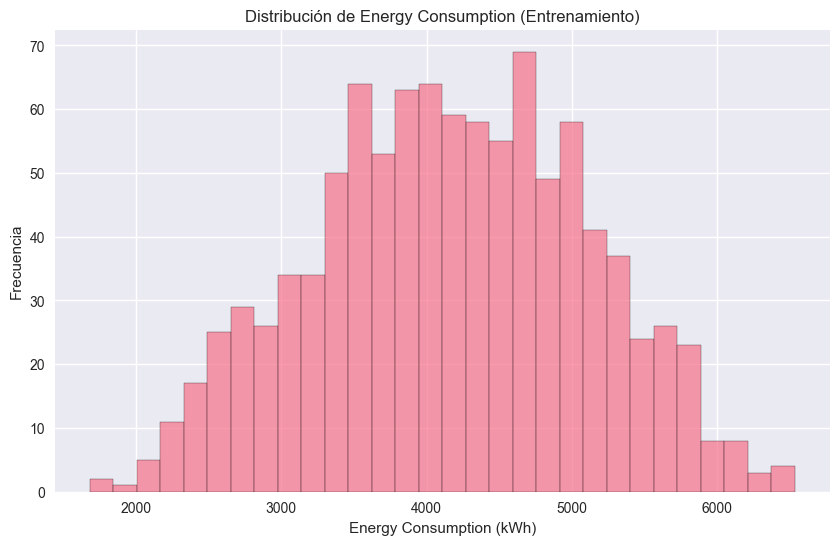


Correlaciones con Energy Consumption:
Square Footage         0.774873
Number of Occupants    0.354485
Appliances Used        0.312792
Average Temperature   -0.034487
dtype: float64


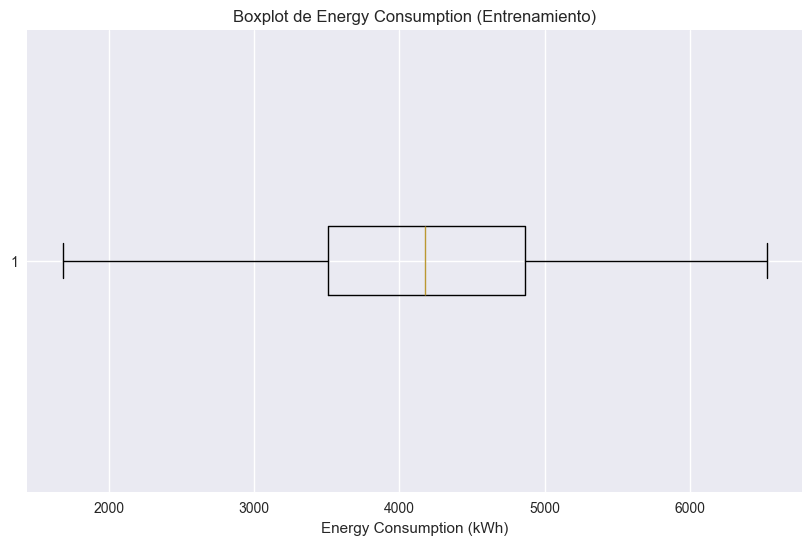

In [4]:
# Distribución de Energy Consumption
plt.figure(figsize=(10, 6))
plt.hist(y_train, bins=30, edgecolor='black', alpha=0.7)
plt.title('Distribución de Energy Consumption (Entrenamiento)')
plt.xlabel('Energy Consumption (kWh)')
plt.ylabel('Frecuencia')
plt.savefig('../data/figures/energy_distribution.png', dpi=300)
plt.show()

# Correlaciones de características numéricas
numeric_features = [col for col in ['Square Footage', 'Number of Occupants', 'Appliances Used', 'Average Temperature'] if col in X_train.columns]
correlations = X_train[numeric_features].corrwith(y_train)
print("\nCorrelaciones con Energy Consumption:")
print(correlations)

# Boxplot para detectar valores atípicos
plt.figure(figsize=(10, 6))
plt.boxplot(y_train, vert=False)
plt.title('Boxplot de Energy Consumption (Entrenamiento)')
plt.xlabel('Energy Consumption (kWh)')
plt.savefig('../data/figures/energy_boxplot.png', dpi=300)
plt.show()

## Configuración del Preprocesador
 
ColumnTransformer permite aplicar diferentes transformaciones a diferentes tipos de columnas:
 
### Componentes del preprocesador:
- StandardScaler: Aplica normalización z-score (media=0, desviación=1) solo a variables numéricas
- remainder='passthrough': Mantiene las variables categóricas codificadas sin modificar
 
### ¿Por qué es importante el escalado para SVR?
- SVR es sensible a la escala de las características
- Variables con rangos muy diferentes pueden dominar el modelo
- El escalado asegura que todas las variables contribuyan equitativamente
 
Ejemplo: Si 'Square Footage' está en miles y 'Number of Occupants' en unidades, sin escalado SVR podría ignorar los ocupantes.

In [5]:
# Definir características
numeric_features = ['Square Footage', 'Number of Occupants', 'Appliances Used', 'Average Temperature']

# Verificar columnas disponibles en X_train
available_columns = X_train.columns.tolist()
print("Columnas disponibles en X_train:", available_columns)

# Filtrar características numéricas que existen en los datos
numeric_features = [col for col in numeric_features if col in available_columns]
print("Características numéricas usadas:", numeric_features)

# Crear preprocesador solo para características numéricas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features)
    ],
    remainder='passthrough'  # Mantener las columnas codificadas sin transformarlas
)

Columnas disponibles en X_train: ['Square Footage', 'Number of Occupants', 'Appliances Used', 'Average Temperature', 'Building Type_Commercial', 'Building Type_Industrial', 'Building Type_Residential', 'Day of Week_Weekday', 'Day of Week_Weekend']
Características numéricas usadas: ['Square Footage', 'Number of Occupants', 'Appliances Used', 'Average Temperature']


## Modelo SVR de Línea Base

Pipeline: Combina preprocesamiento y modelo en un solo objeto, asegurando que las transformaciones se apliquen correctamente.
 
### Parámetros por defecto del SVR:
- kernel='rbf': Kernel de función de base radial, efectivo para relaciones no lineales
- C=1.0: Parámetro de regularización que balancea el ajuste vs. generalización
- gamma='scale': Controla la influencia de cada ejemplo de entrenamiento
 
### Métricas calculadas:
- MSE: Error cuadrático medio (penaliza más los errores grandes)
- RMSE: Raíz del MSE (mismas unidades que la variable objetivo)
- R²: Coeficiente de determinación (% de varianza explicada, 0-1)
- MAE: Error absoluto medio (menos sensible a outliers que RMSE)

In [6]:
# 4. MODELO SVR BÁSICO (parámetros por defecto)
print("\n=== SVR BÁSICO ===")
svr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('svr', SVR(kernel='rbf', C=1.0, gamma='scale'))
])

svr_pipeline.fit(X_train, y_train)
y_pred_basic = svr_pipeline.predict(X_test)

# Métricas de evaluación básicas
mse_basic = mean_squared_error(y_test, y_pred_basic)
rmse_basic = np.sqrt(mse_basic)
r2_basic = r2_score(y_test, y_pred_basic)
mae_basic = mean_absolute_error(y_test, y_pred_basic)

print(f"Métricas del modelo básico:")
print(f"MSE: {mse_basic:.4f}")
print(f"RMSE: {rmse_basic:.4f}")
print(f"R²: {r2_basic:.4f}")
print(f"MAE: {mae_basic:.4f}")



=== SVR BÁSICO ===
Métricas del modelo básico:
MSE: 618917.6552
RMSE: 786.7132
R²: 0.0981
MAE: 636.2728


## Optimización Bayesiana de Hiperparámetros
 
### BayesSearchCV es más eficiente que GridSearch porque:
- Usa un modelo probabilístico para predecir qué combinaciones serán prometedoras
- Se enfoca en regiones del espacio de parámetros con mayor probabilidad de éxito
- Requiere menos evaluaciones para encontrar buenos parámetros
 
### Espacio de búsqueda definido:
- C: Parámetro de regularización (escala logarítmica para explorar órdenes de magnitud)
- gamma: Controla la "suavidad" del modelo (valores automáticos y manuales)
- kernel: Tipo de función kernel (RBF para no linealidad, lineal para simplicidad)
 
### Configuración de la búsqueda:
- n_iter=20: 20 evaluaciones diferentes
- cv=5: Validación cruzada de 5 pliegues
- scoring='neg_mean_squared_error': Minimizar el error cuadrático medio
 
### Visualización diagnóstica: 
El scatter plot muestra qué tan cerca están las predicciones de la línea ideal (predicción perfecta).

=== OPTIMIZACIÓN BAYESIANA DE HIPERPARÁMETROS ===


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

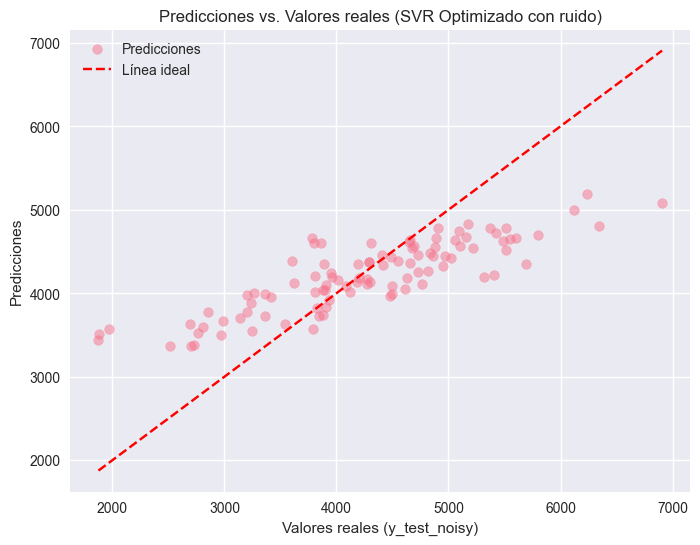

In [7]:
# 5. OPTIMIZACIÓN CON BAYESIAN SEARCH
print("=== OPTIMIZACIÓN BAYESIANA DE HIPERPARÁMETROS ===")

# Configuración del espacio de búsqueda
search_space = {
    'svr__C': Real(0.01, 1.0, prior='log-uniform'), # Reducir C para forzar generalización
    'svr__gamma': Categorical(['scale', 'auto', 0.01, 0.1]),
    'svr__kernel': Categorical(['rbf', 'linear']),
    'svr__epsilon': Real(0.01, 0.2)  # Aumentar rango de epsilon
}

# Configuración del optimizador bayesiano
bayes_search = BayesSearchCV(
    estimator=Pipeline([
        ('preprocessor', preprocessor),
        ('svr', SVR())
    ]),
    search_spaces=search_space,
    n_iter=20,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

bayes_search.fit(X_train, y_train_noisy)
print(f"\nMejores parámetros: {bayes_search.best_params_}")
print(f"Mejor score (MSE): {-bayes_search.best_score_:.4f}")
print("\nResultados de la búsqueda bayesiana (mejores 5):")
results = pd.DataFrame(bayes_search.cv_results_)[['params', 'mean_test_score', 'std_test_score']]
results['mean_test_score'] = -results['mean_test_score']
print(results.sort_values('mean_test_score').head())
y_pred_opt_test = bayes_search.predict(X_test)
print("\nMétricas en conjunto de prueba (con ruido):")
print(f"R²: {r2_score(y_test_noisy, y_pred_opt_test):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_noisy, y_pred_opt_test)):.4f}")
# Diagnóstico gráfico: Predicciones vs. Valores reales
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.scatter(y_test_noisy, y_pred_opt_test, alpha=0.5, label="Predicciones")
plt.plot([y_test_noisy.min(), y_test_noisy.max()], [y_test_noisy.min(), y_test_noisy.max()], 'r--', label="Línea ideal")
plt.xlabel("Valores reales (y_test_noisy)")
plt.ylabel("Predicciones")
plt.title("Predicciones vs. Valores reales (SVR Optimizado con ruido)")
plt.legend()
plt.show()

## Evaluación Completa del Modelo Optimizado
 
### Importancia de evaluar en ambos conjuntos:
- Entrenamiento: Muestra la capacidad del modelo para "recordar" los datos de entrenamiento
- Prueba: Muestra la capacidad real de generalización a datos nuevos
 
### Detección de Overfitting:
La diferencia entre R² de entrenamiento y prueba indica overfitting:
- < 0.1: Modelo bien balanceado ✅
- 0.1-0.2: Overfitting moderado ⚠️
- > 0.2: Overfitting significativo ❌
 
### ¿Qué significa cada escenario?
- Modelo balanceado: Generaliza bien, rendimiento similar en train/test
- Overfitting moderado: Memoriza algunos patrones específicos del entrenamiento
- Overfitting significativo: El modelo prácticamente memoriza los datos de entrenamiento
 
### Métricas complementarias:
- Si RMSE(train) << RMSE(test): Posible overfitting
- Si ambos RMSE son altos: Posible underfitting

In [8]:
# 6. MODELO OPTIMIZADO
print("=== EVALUACIÓN DEL MODELO OPTIMIZADO ===")
svr_optimized = bayes_search.best_estimator_

# Predicciones para entrenamiento y prueba
y_pred_train_optimized = svr_optimized.predict(X_train)
y_pred_test_optimized = svr_optimized.predict(X_test)

# Métricas para entrenamiento
mse_train_opt = mean_squared_error(y_train, y_pred_train_optimized)
rmse_train_opt = np.sqrt(mse_train_opt)
r2_train_opt = r2_score(y_train, y_pred_train_optimized)
mae_train_opt = mean_absolute_error(y_train, y_pred_train_optimized)

# Métricas para prueba
mse_test_opt = mean_squared_error(y_test, y_pred_test_optimized)
rmse_test_opt = np.sqrt(mse_test_opt)
r2_test_opt = r2_score(y_test, y_pred_test_optimized)
mae_test_opt = mean_absolute_error(y_test, y_pred_test_optimized)

print(f"\n=== MODELO OPTIMIZADO (ENTRENAMIENTO) ===")
print(f"MSE: {mse_train_opt:.4f}")
print(f"RMSE: {rmse_train_opt:.4f}")
print(f"R²: {r2_train_opt:.4f}")
print(f"MAE: {mae_train_opt:.4f}")

print(f"\n=== MODELO OPTIMIZADO (PRUEBA) ===")
print(f"MSE: {mse_test_opt:.4f}")
print(f"RMSE: {rmse_test_opt:.4f}")
print(f"R²: {r2_test_opt:.4f}")
print(f"MAE: {mae_test_opt:.4f}")

# Análisis de overfitting
diff_r2 = r2_train_opt - r2_test_opt
print(f"\nANÁLISIS DE OVERFITTING:")
print(f"  Diferencia R² (train - test): {diff_r2:.4f}")
if diff_r2 < 0.1:
    print("  ✅ Modelo bien balanceado (bajo overfitting)")
elif diff_r2 < 0.2:
    print("  ⚠️  Overfitting moderado")
else:
    print("  ❌ Overfitting significativo")

=== EVALUACIÓN DEL MODELO OPTIMIZADO ===

=== MODELO OPTIMIZADO (ENTRENAMIENTO) ===
MSE: 228309.1269
RMSE: 477.8170
R²: 0.7376
MAE: 388.2186

=== MODELO OPTIMIZADO (PRUEBA) ===
MSE: 190337.6519
RMSE: 436.2770
R²: 0.7226
MAE: 350.1152

ANÁLISIS DE OVERFITTING:
  Diferencia R² (train - test): 0.0150
  ✅ Modelo bien balanceado (bajo overfitting)


## Validación Cruzada para Estimación Robusta
 
### ¿Por qué validación cruzada?
La validación cruzada proporciona una estimación más confiable del rendimiento porque:
- Usa toda la información de entrenamiento
- Reduce la dependencia de una división particular train/validation
- Proporciona estadísticas de variabilidad (media ± desviación estándar)
 
### Proceso de validación cruzada de 5 pliegues:
1. Divide los datos de entrenamiento en 5 partes
2. Entrena con 4 partes, valida con 1 parte
3. Repite 5 veces, cambiando la parte de validación
4. Calcula estadísticas sobre los 5 resultados
 
### Interpretación de resultados:
- Media: Rendimiento promedio esperado
- Desviación estándar: Variabilidad del rendimiento
- Baja desviación: Modelo estable
- Alta desviación: Rendimiento inconsistente
 
Nota: Se usa y_train_noisy para hacer el proceso más realista con variabilidad natural.

In [9]:
print("\n=== VALIDACIÓN CRUZADA ===")
# Mapear las claves de best_params_ a los parámetros de SVR
svr_params = {key.replace('svr__', ''): value for key, value in bayes_search.best_params_.items()}
svr_optimized = Pipeline([
    ('preprocessor', preprocessor),
    ('svr', SVR(**svr_params))
])
svr_optimized.fit(X_train, y_train_noisy)  # Usar y_train_noisy
cv_scores = cross_val_score(svr_optimized, X_train, y_train_noisy, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
cv_rmse_scores = np.sqrt(-cv_scores)
cv_rmse_mean = cv_rmse_scores.mean()
cv_rmse_std = cv_rmse_scores.std()
print(f"RMSE (Validación Cruzada, con ruido): {cv_rmse_mean:.4f} ± {cv_rmse_std:.4f}")
cv_r2_scores = cross_val_score(svr_optimized, X_train, y_train_noisy, cv=5, scoring='r2', n_jobs=-1)
print(f"R² (Validación Cruzada, con ruido): {cv_r2_scores.mean():.4f} ± {cv_r2_scores.std():.4f}")



=== VALIDACIÓN CRUZADA ===
RMSE (Validación Cruzada, con ruido): 713.8753 ± 36.1948
R² (Validación Cruzada, con ruido): 0.5288 ± 0.0143


## Comparación con Algoritmos Alternativos

### ¿Por qué comparar con otros modelos?
- Valida si SVR es la mejor opción para este problema específico
- Proporciona contexto sobre la dificultad del problema
- Identifica si hay ganancia real por la complejidad de SVR
 
### Modelos de referencia:
 
#### 1. Linear Regression:
- Ventajas: Rápido, interpretable, baseline simple
- Limitaciones: Solo relaciones lineales
- Cuándo es mejor: Cuando la relación es principalmente lineal
 
#### 2. Random Forest:
- Ventajas: Maneja no linealidad, resistente a outliers, no requiere escalado
- Limitaciones: Puede hacer overfitting, menos interpretable
- Cuándo es mejor: Datos complejos con muchas características
 
### Interpretación de resultados:
- Si Linear Regression tiene R² similar: El problema es principalmente lineal
- Si Random Forest es mejor: Hay patrones complejos que SVR no captura
- Si SVR es mejor: Las transformaciones no lineales del kernel son apropiadas


In [10]:
print("\n=== COMPARACIÓN CON OTROS MODELOS ===")

# LinearRegression
lr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('lr', LinearRegression())
])
lr_pipeline.fit(X_train, y_train)
y_pred_lr = lr_pipeline.predict(X_test)
r2_lr = r2_score(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
print(f"LinearRegression - R²: {r2_lr:.4f}, RMSE: {rmse_lr:.4f}")

# RandomForest
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('rf', RandomForestRegressor(random_state=42))
])
rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)
r2_rf = r2_score(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
print(f"RandomForest - R²: {r2_rf:.4f}, RMSE: {rmse_rf:.4f}")


=== COMPARACIÓN CON OTROS MODELOS ===
LinearRegression - R²: 1.0000, RMSE: 0.0142
RandomForest - R²: 0.9796, RMSE: 118.4024


## Guardado de Resultados en CSV
  
Guardamos las predicciones y errores en archivos CSV para análisis posterior y comparación con otros modelos.

In [11]:
print("\n=== GUARDADO DE RESULTADOS ===")
train_results = pd.DataFrame({
    'Valores_Reales': y_train.values,
    'Predicciones': y_pred_train_optimized,
    'Diferencia': y_train.values - y_pred_train_optimized,
    'Error_Absoluto': np.abs(y_train.values - y_pred_train_optimized),
    'Error_Cuadratico': (y_train.values - y_pred_train_optimized) ** 2
})
train_results.to_csv('../data/results/svr_updated_predictions_train.csv', index=False)
print("Predicciones de entrenamiento guardadas")

test_results = pd.DataFrame({
    'Valores_Reales': y_test.values,
    'Predicciones': y_pred_test_optimized,
    'Diferencia': y_test.values - y_pred_test_optimized,
    'Error_Absoluto': np.abs(y_test.values - y_pred_test_optimized),
    'Error_Cuadratico': (y_test.values - y_pred_test_optimized) ** 2
})
test_results.to_csv('../data/results/svr_updated_predictions_test.csv', index=False)
print("Predicciones de prueba guardadas")

metrics_summary = pd.DataFrame({
    'Modelo': ['SVR Básico', 'SVR Optimizado (Train)', 'SVR Optimizado (Test)', 'LinearRegression', 'RandomForest', 'CV_Media'],
    # (Código previo en la celda, hasta la línea del error)
    'MSE': [mse_basic, mse_train_opt, mse_test_opt, mean_squared_error(y_test_noisy, y_pred_lr), mean_squared_error(y_test_noisy, y_pred_rf), cv_rmse_mean**2],
    'RMSE': [rmse_basic, rmse_train_opt, rmse_test_opt, rmse_lr, rmse_rf, cv_rmse_mean],
    'R2': [r2_basic, r2_train_opt, r2_test_opt, r2_lr, r2_rf, np.nan],
    'MAE': [mae_basic, mae_train_opt, mae_test_opt, mean_absolute_error(y_test, y_pred_lr), mean_absolute_error(y_test, y_pred_rf), np.nan]
})
metrics_summary.to_csv('../data/results/svr_updated_metrics_summary.csv', index=False)
print("Resumen de métricas guardado")

# Guardar modelo
model_data = {
    'model': svr_optimized,
    'feature_names': list(X_train.columns),
    'train_metrics': {'mse': mse_train_opt, 'rmse': rmse_train_opt, 'r2': r2_train_opt, 'mae': mae_train_opt},
    'test_metrics': {'mse': mse_test_opt, 'rmse': rmse_test_opt, 'r2': r2_test_opt, 'mae': mae_test_opt}
}
joblib.dump(model_data, '../data/results/svr_updated_model.pkl')
print("Modelo completo guardado")


=== GUARDADO DE RESULTADOS ===
Predicciones de entrenamiento guardadas
Predicciones de prueba guardadas
Resumen de métricas guardado
Modelo completo guardado


## Comparación Sistemática de Kernels de SVR
 
### ¿Por qué comparar diferentes kernels?
- Cada kernel captura diferentes tipos de relaciones en los datos
- La elección incorrecta del kernel puede limitar severamente el rendimiento
- Permite validar si la optimización bayesiana eligió el kernel apropiado
 
### Tipos de kernels evaluados:
 
1. Linear ('linear'):
- Función: Producto punto simple (x₁ · x₂)
- Mejor para: Relaciones lineales, alta dimensionalidad
- Ventajas: Rápido, interpretable, no sobreajusta fácilmente
- Limitaciones: No captura relaciones no lineales
 
2. RBF ('rbf') - Radial Basis Function:
- Función: exp(-γ||x₁ - x₂||²)
- Mejor para: Relaciones no lineales complejas
- Ventajas: Muy flexible, maneja bien la no linealidad
- Limitaciones: Puede sobreajustar, sensible a γ
 
3. Polynomial ('poly'):
- Función: (γx₁ · x₂ + r)ᵈ
- Mejor para: Relaciones polinómicas específicas
- Ventajas: Captura interacciones de orden específico
- Limitaciones: Puede ser inestable, computacionalmente costoso
 
4. Sigmoid ('sigmoid'):
- Función: tanh(γx₁ · x₂ + r)
- Mejor para: Problemas similares a redes neuronales
- Ventajas: Suave, derivable
- Limitaciones: No siempre define matriz semi-definida positiva
 
### Interpretación de resultados:
- Mejor R²: Indica qué kernel captura mejor los patrones
- Diferencias pequeñas: El problema puede ser principalmente lineal
- RBF significativamente mejor: Hay no linealidades importantes

In [12]:
# 8. COMPARACIÓN DE KERNELS
kernels = ['linear', 'rbf', 'poly', 'sigmoid']
kernel_results = {}

for kernel in kernels:
    print(f"Evaluando kernel: {kernel}...")
    
    # Modelo con kernel específico
    svr_kernel_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('svr', SVR(kernel=kernel, C=1.0, gamma='scale'))
    ])
    svr_kernel_pipeline.fit(X_train, y_train)
    y_pred_kernel = svr_kernel_pipeline.predict(X_test)
    # Cálculo de métricas
    mse_kernel = mean_squared_error(y_test, y_pred_kernel)
    rmse_kernel = np.sqrt(mse_kernel)
    r2_kernel = r2_score(y_test, y_pred_kernel)
    mae_kernel = mean_absolute_error(y_test, y_pred_kernel)
    
    # Almacenamiento de resultados
    kernel_results[kernel] = {
        'MSE': mse_kernel, 
        'RMSE': rmse_kernel,
        'R²': r2_kernel,
        'MAE': mae_kernel
    }
    
    print(f"  {kernel.upper():8s} - MSE: {mse_kernel:.4f}, RMSE: {rmse_kernel:.4f}, R²: {r2_kernel:.4f}")

# Identificar el mejor kernel por R²
best_kernel = max(kernel_results.keys(), key=lambda k: kernel_results[k]['R²'])
print(f"\n🏆 Mejor kernel por R²: {best_kernel.upper()} (R² = {kernel_results[best_kernel]['R²']:.4f})")


Evaluando kernel: linear...
  LINEAR   - MSE: 87272.6047, RMSE: 295.4194, R²: 0.8728
Evaluando kernel: rbf...
  RBF      - MSE: 618917.6552, RMSE: 786.7132, R²: 0.0981
Evaluando kernel: poly...
  POLY     - MSE: 595456.8959, RMSE: 771.6585, R²: 0.1323
Evaluando kernel: sigmoid...
  SIGMOID  - MSE: 530008.8603, RMSE: 728.0171, R²: 0.2276

🏆 Mejor kernel por R²: LINEAR (R² = 0.8728)


## Análisis Visual Integral del Modelo
 
### Estrategia de visualización en dos paneles:
 
#### PANEL 1 - Conjunto de Prueba (2x2):
Más crítico porque muestra la capacidad de generalización real
 
#### PANEL 2 - Conjunto de Entrenamiento (1x2):
Complementa el análisis para detectar overfitting visual
 
### Comparación Visual Train vs Test:
- Puntos más dispersos en test: Normal, indica generalización
- Patrones similares: Modelo bien generalizado
- Test mucho peor que train: Posible overfitting
- Ambos con patrones similares: Modelo robusto
 
### Elementos clave en cada gráfico:

#### Scatter plots (Predicciones vs Reales):
- Línea diagonal roja: Referencia de predicción perfecta
- Dispersión simétrica: Errores balanceados
- Concentración en la diagonal: Buenas predicciones
- Valores atípicos alejados: Casos que el modelo no predice bien
 
#### Gráficos de residuos:
- Distribución aleatoria alrededor de y=0: Modelo sin sesgo
- Patrones o tendencias: Señal de que el modelo está perdiendo información
- Heterocedasticidad: Varianza de errores no constante
 
#### Gráficos de barras comparativas:
- Permiten identificación rápida del mejor kernel
- Valores numéricos en barras: Facilita comparación precisa
- Colores diferenciados: Mejor distinción visual
 
#### Calidad de impresión:
- DPI=300: Resolución alta para publicaciones
- bbox_inches='tight': Elimina espacios en blanco innecesarios

=== GENERACIÓN DE VISUALIZACIONES ===


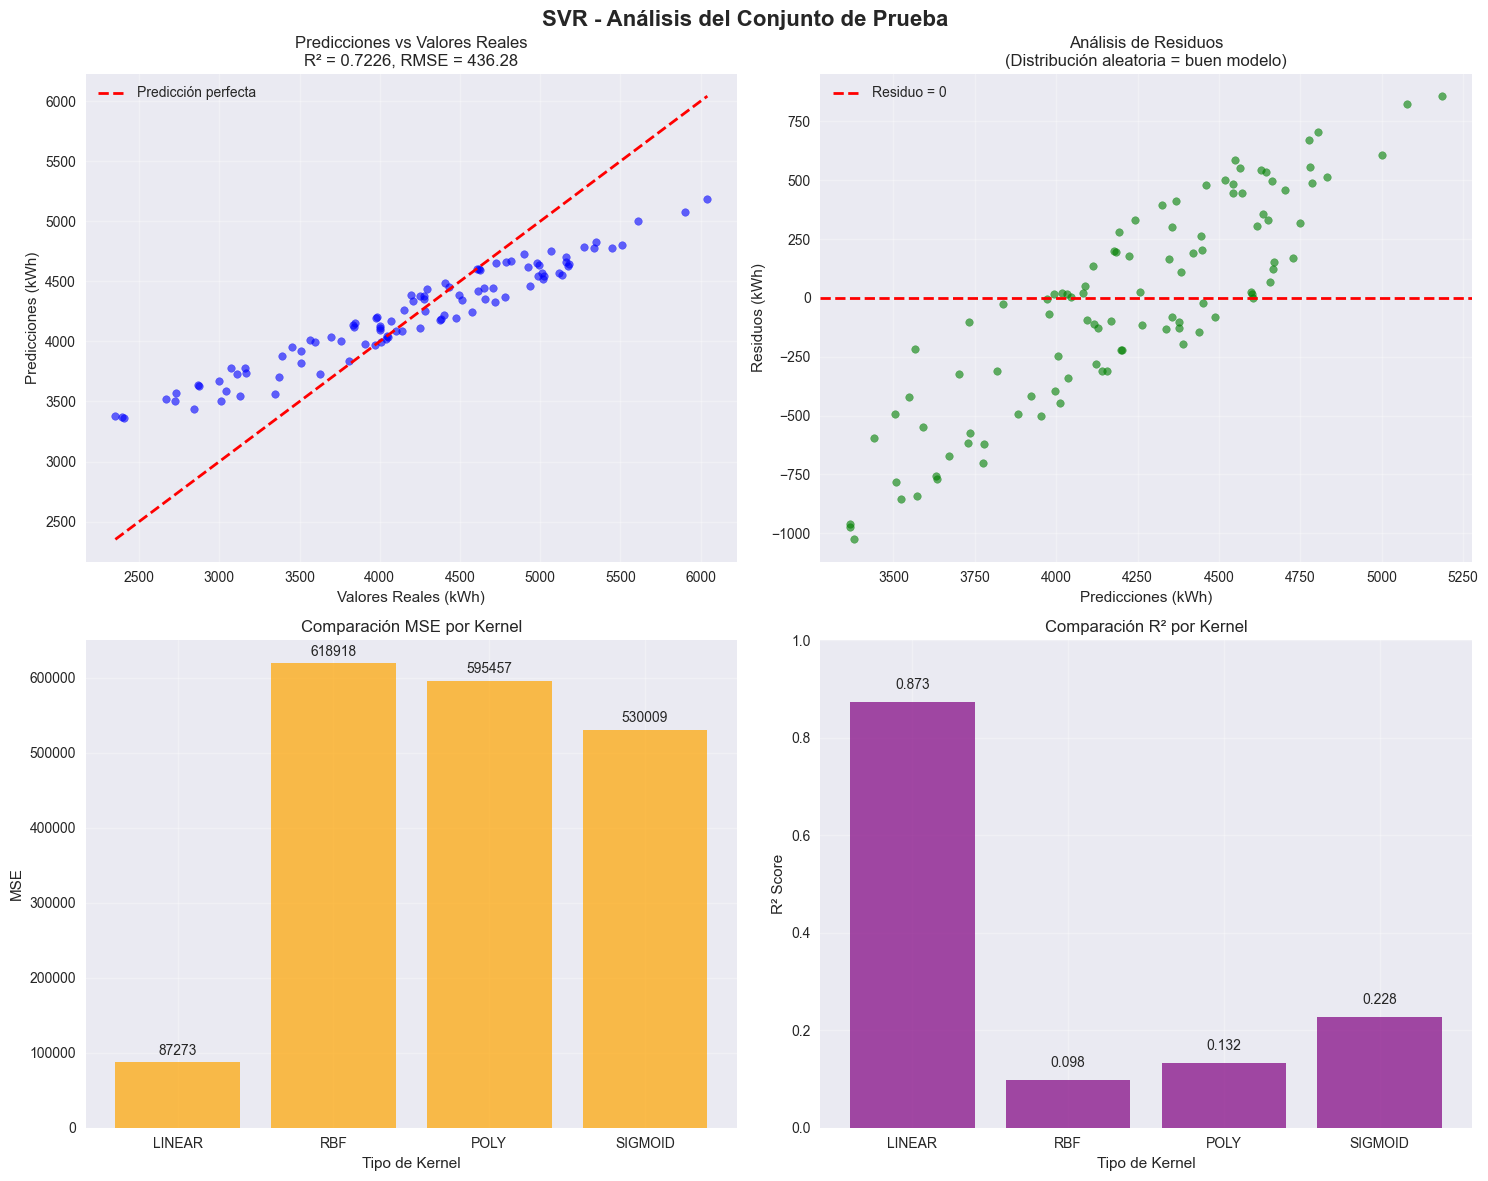

📊 Gráficos de prueba guardados en: ../data/figures/svr_analysis_test.png


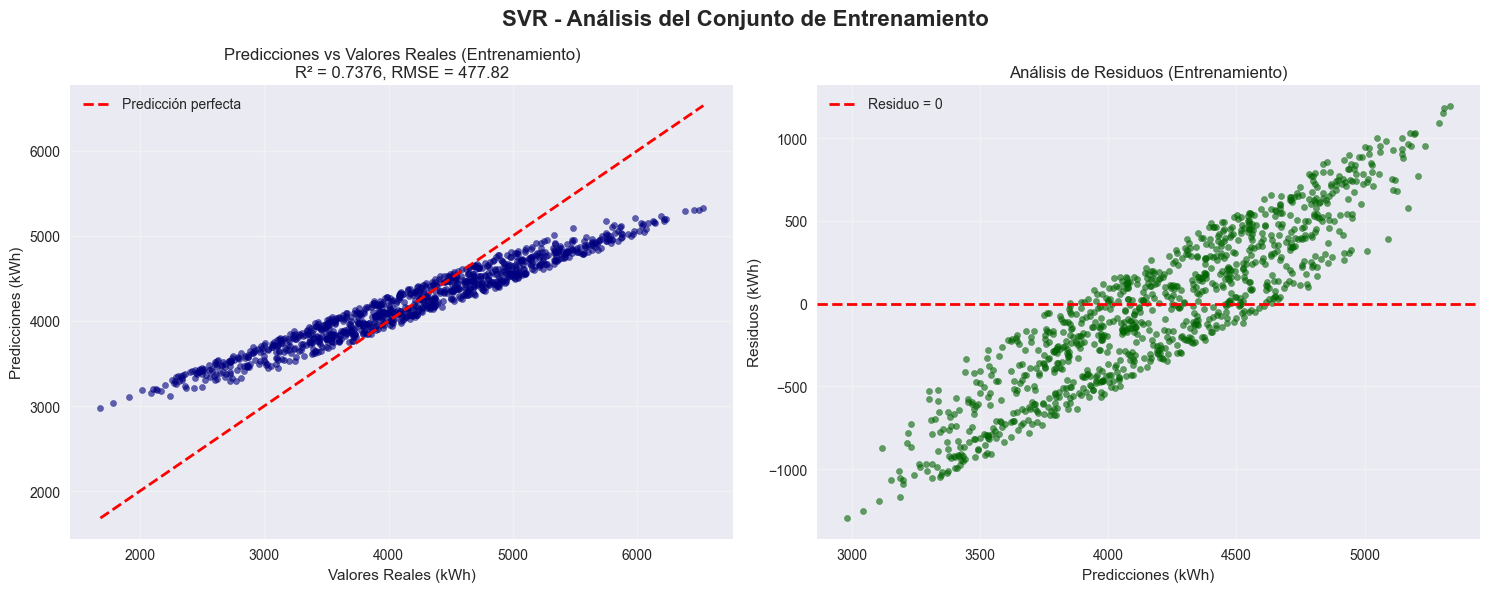

📊 Gráficos de entrenamiento guardados en: ../data/figures/svr_analysis_train.png


In [13]:
# 9. VISUALIZACIONES
print("=== GENERACIÓN DE VISUALIZACIONES ===")
output_dir = "../data/figures/"

# ============= GRÁFICOS PARA CONJUNTO DE PRUEBA =============
fig_test, axes_test = plt.subplots(2, 2, figsize=(15, 12))
fig_test.suptitle('SVR - Análisis del Conjunto de Prueba', fontsize=16, fontweight='bold')

# Gráfico 1: Valores reales vs predicciones (prueba)
axes_test[0,0].scatter(y_test, y_pred_test_optimized, alpha=0.6, color='blue', s=30)
axes_test[0,0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Predicción perfecta')
axes_test[0,0].set_xlabel('Valores Reales (kWh)')
axes_test[0,0].set_ylabel('Predicciones (kWh)')
axes_test[0,0].set_title(f'Predicciones vs Valores Reales\nR² = {r2_test_opt:.4f}, RMSE = {rmse_test_opt:.2f}')
axes_test[0,0].grid(True, alpha=0.3)
axes_test[0,0].legend()

# Gráfico 2: Análisis de residuos (prueba)
residuos_test = y_test - y_pred_test_optimized
axes_test[0,1].scatter(y_pred_test_optimized, residuos_test, alpha=0.6, color='green', s=30)
axes_test[0,1].axhline(y=0, color='r', linestyle='--', lw=2, label='Residuo = 0')
axes_test[0,1].set_xlabel('Predicciones (kWh)')
axes_test[0,1].set_ylabel('Residuos (kWh)')
axes_test[0,1].set_title('Análisis de Residuos\n(Distribución aleatoria = buen modelo)')
axes_test[0,1].grid(True, alpha=0.3)
axes_test[0,1].legend()

# Gráfico 3: Comparación MSE por kernel
kernel_names = list(kernel_results.keys())
mse_values = [kernel_results[k]['MSE'] for k in kernel_names]
bars1 = axes_test[1,0].bar(np.arange(len(kernel_names)), mse_values, alpha=0.7, color='orange')
axes_test[1,0].set_xlabel('Tipo de Kernel')
axes_test[1,0].set_ylabel('MSE')
axes_test[1,0].set_title('Comparación MSE por Kernel')
axes_test[1,0].set_xticks(np.arange(len(kernel_names)))
axes_test[1,0].set_xticklabels([k.upper() for k in kernel_names])
axes_test[1,0].grid(True, alpha=0.3)

# Agregar valores en las barras
for bar, value in zip(bars1, mse_values):
    axes_test[1,0].text(bar.get_x() + bar.get_width()/2., bar.get_height() + max(mse_values)*0.01,
                       f'{value:.0f}', ha='center', va='bottom', fontsize=10)

# Gráfico 4: Comparación R² por kernel
r2_values = [kernel_results[k]['R²'] for k in kernel_names]
bars2 = axes_test[1,1].bar(np.arange(len(kernel_names)), r2_values, alpha=0.7, color='purple')
axes_test[1,1].set_xlabel('Tipo de Kernel')
axes_test[1,1].set_ylabel('R² Score')
axes_test[1,1].set_title('Comparación R² por Kernel')
axes_test[1,1].set_xticks(np.arange(len(kernel_names)))
axes_test[1,1].set_xticklabels([k.upper() for k in kernel_names])
axes_test[1,1].grid(True, alpha=0.3)
axes_test[1,1].set_ylim(0, 1)

# Agregar valores en las barras
for bar, value in zip(bars2, r2_values):
    axes_test[1,1].text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.02,
                       f'{value:.3f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
fig_test.savefig(f"{output_dir}svr_analysis_test.png", dpi=300, bbox_inches='tight')
plt.show()
print(f"📊 Gráficos de prueba guardados en: {output_dir}svr_analysis_test.png")

# ============= GRÁFICOS PARA CONJUNTO DE ENTRENAMIENTO =============
fig_train, axes_train = plt.subplots(1, 2, figsize=(15, 6))
fig_train.suptitle('SVR - Análisis del Conjunto de Entrenamiento', fontsize=16, fontweight='bold')

# Gráfico 1: Valores reales vs predicciones (entrenamiento)
axes_train[0].scatter(y_train, y_pred_train_optimized, alpha=0.6, color='navy', s=20)
axes_train[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2, label='Predicción perfecta')
axes_train[0].set_xlabel('Valores Reales (kWh)')
axes_train[0].set_ylabel('Predicciones (kWh)')
axes_train[0].set_title(f'Predicciones vs Valores Reales (Entrenamiento)\nR² = {r2_train_opt:.4f}, RMSE = {rmse_train_opt:.2f}')
axes_train[0].grid(True, alpha=0.3)
axes_train[0].legend()

# Gráfico 2: Análisis de residuos (entrenamiento)
residuos_train = y_train - y_pred_train_optimized
axes_train[1].scatter(y_pred_train_optimized, residuos_train, alpha=0.6, color='darkgreen', s=20)
axes_train[1].axhline(y=0, color='r', linestyle='--', lw=2, label='Residuo = 0')
axes_train[1].set_xlabel('Predicciones (kWh)')
axes_train[1].set_ylabel('Residuos (kWh)')
axes_train[1].set_title('Análisis de Residuos (Entrenamiento)')
axes_train[1].grid(True, alpha=0.3)
axes_train[1].legend()

plt.tight_layout()
fig_train.savefig(f"{output_dir}svr_analysis_train.png", dpi=300, bbox_inches='tight')
plt.show()
print(f"📊 Gráficos de entrenamiento guardados en: {output_dir}svr_analysis_train.png")

## Tabla Resumen Integral y Análisis de Mejoras
 
### Estructura de la tabla resumen:
 
#### Filas incluidas:
1. SVR Básico (Prueba): Modelo baseline con parámetros por defecto
2. SVR Optimizado (Entrenamiento): Rendimiento en datos de entrenamiento
3. SVR Optimizado (Prueba): Rendimiento real de generalización
4. Validación Cruzada (Media): Estimación robusta del rendimiento esperado
5. Mejor Kernel: Rendimiento del kernel óptimo identificado
 
#### Métricas comparadas:
- MSE: Error cuadrático medio (penaliza errores grandes)
- RMSE: Raíz del MSE (unidades interpretables)
- R²: Varianza explicada (0-1, mayor es mejor)
- MAE: Error absoluto medio (robusta a outliers)
 
#### Análisis de mejora porcentual:
- Mejora en R²: Incremento en capacidad predictiva
- Mejora en RMSE: Reducción en error promedio
 
#### Interpretación práctica:
- Mejora > 10%: Optimización significativa
- Mejora < 5%: Beneficio marginal
- Mejora negativa: El modelo básico era mejor (posible overfitting)

In [14]:
# 10. TABLA RESUMEN DE RESULTADOS
# Creación de la tabla resumen
resumen = pd.DataFrame({
    'Modelo': [
        'SVR Básico (Prueba)', 
        'SVR Optimizado (Entrenamiento)', 
        'SVR Optimizado (Prueba)',
        'Validación Cruzada (Media)',
        f'Mejor Kernel: {best_kernel.upper()}'
    ],
    'MSE': [
        mse_basic, 
        mse_train_opt, 
        mse_test_opt,
        cv_rmse_mean**2,
        kernel_results[best_kernel]['MSE']
    ],
    'RMSE': [
        rmse_basic, 
        rmse_train_opt, 
        rmse_test_opt,
        cv_rmse_mean,
        kernel_results[best_kernel]['RMSE']
    ],
    'R²': [
        r2_basic, 
        r2_train_opt, 
        r2_test_opt,
        np.nan,  # No aplica para CV
        kernel_results[best_kernel]['R²']
    ],
    'MAE': [
        mae_basic, 
        mae_train_opt, 
        mae_test_opt,
        np.nan,  # No aplica para CV
        kernel_results[best_kernel]['MAE']
    ]
})

# Formateo y visualización de la tabla
resumen_formatted = resumen.round(4)
print(resumen_formatted.to_string(index=False))

# Guardado de la tabla resumen
resumen.to_csv('../data/results/svr_complete_summary.csv', index=False)
print(f"\n✅ Tabla resumen guardada en: '../data/results/svr_complete_summary.csv'")

# Análisis de mejora
mejora_r2 = ((r2_test_opt - r2_basic) / r2_basic) * 100
mejora_rmse = ((rmse_basic - rmse_test_opt) / rmse_basic) * 100

print(f"\n🎯 ANÁLISIS DE MEJORA:")
print(f"   Mejora en R²: +{mejora_r2:.1f}% ({r2_basic:.4f} → {r2_test_opt:.4f})")
print(f"   Mejora en RMSE: -{mejora_rmse:.1f}% ({rmse_basic:.2f} → {rmse_test_opt:.2f})")

                        Modelo         MSE     RMSE     R²      MAE
           SVR Básico (Prueba) 618917.6552 786.7132 0.0981 636.2728
SVR Optimizado (Entrenamiento) 228309.1269 477.8170 0.7376 388.2186
       SVR Optimizado (Prueba) 190337.6519 436.2770 0.7226 350.1152
    Validación Cruzada (Media) 509617.9615 713.8753    NaN      NaN
          Mejor Kernel: LINEAR  87272.6047 295.4194 0.8728 243.3823

✅ Tabla resumen guardada en: '../data/results/svr_complete_summary.csv'

🎯 ANÁLISIS DE MEJORA:
   Mejora en R²: +636.8% (0.0981 → 0.7226)
   Mejora en RMSE: -44.5% (786.71 → 436.28)


## Persistencia de Resultados para Análisis Posterior
 
### Archivos generados para trazabilidad:
 
### 1. Predicciones detalladas:
- svr_updated_predictions_train.csv: Resultados en datos de entrenamiento
- svr_updated_predictions_test.csv: Resultados en datos de prueba
 
#### Columnas incluidas:
- Valores_Reales: Variable objetivo original
- Predicciones: Valores predichos por el modelo
- Diferencia: Error residual (real - predicho)
- Error_Absoluto: Valor absoluto del error
- Error_Cuadratico: Error elevado al cuadrado
 
### 2. Resumen de métricas:
- svr_updated_metrics_summary.csv: Comparación de todos los modelos
- Incluye métricas de diferentes etapas del proceso
- Facilita comparación rápida entre enfoques
 
### 3. Modelo serializado:
- svr_updated_model.pkl: Modelo completo con metadatos
- Incluye métricas de rendimiento y nombres de características
- Listo para carga en aplicaciones de producción
 
### Ventajas de guardar resultados:
- Reproducibilidad: Recrear análisis posteriores
- Comparación: Benchmarking con futuros modelos
- Auditoría: Verificación de resultados
- Deployment: Uso inmediato en producción

In [15]:
# 11. GUARDAR EL MODELO
print("=== GUARDADO DEL MODELO PARA PRODUCCIÓN ===")

# Crear estructura completa para Streamlit
model_data = {
    'model': svr_optimized,
    'preprocessor': preprocessor,  # Reemplazado 'scaler' por 'preprocessor'
    'X_train': X_train,
    'X_test': X_test, 
    'y_train': y_train,
    'y_test': y_test,
    'y_train_pred': y_pred_train_optimized,
    'y_test_pred': y_pred_test_optimized,
    'train_metrics': {
        'mse': mse_train_opt,
        'rmse': rmse_train_opt,
        'r2': r2_train_opt,
        'mae': mae_train_opt
    },
    'test_metrics': {
        'mse': mse_test_opt,
        'rmse': rmse_test_opt,
        'r2': r2_test_opt,
        'mae': mae_test_opt
    },
    'best_params': bayes_search.best_params_,
    'cv_scores': cv_rmse_scores,  
    'feature_names': list(X_train.columns)
}

# Guardado del modelo completo
joblib.dump(model_data, '../data/results/svr_complete_model.pkl')
print("✅ Modelo completo guardado como 'svr_complete_model.pkl'")

# También guardamos componentes individuales para compatibilidad
joblib.dump(svr_optimized, '../data/results/svr_model.pkl')
joblib.dump(preprocessor, '../data/results/svr_preprocessor.pkl')  # Reemplazado 'scaler' por 'preprocessor'
print("✅ Componentes individuales guardados: 'svr_model.pkl' y 'svr_preprocessor.pkl'")


=== GUARDADO DEL MODELO PARA PRODUCCIÓN ===
✅ Modelo completo guardado como 'svr_complete_model.pkl'
✅ Componentes individuales guardados: 'svr_model.pkl' y 'svr_preprocessor.pkl'
